# A short user guide to python tools for visualization and analysis of interferometric data

* ```BaseInterferometry```class is the base class that provides functionality  for analysis of interferometric data.
* Current analysis tools:
    - Fourier transform
    - Wigner-Ville transform
* ```Interferogram``` class is for experimental interferograms.
* ```Simulation``` class is for simulated interferograms.
* Simulations include:
    - Pulse profile
    - Interferogram itself



In [50]:
#import packages
import sys
import glob, os
from parse import parse

# set source path
codepath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry")
if codepath not in sys.path:
    sys.path.append(codepath)

#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experimental interferograms

In [51]:
from Interferometry.classes.interferogram import Interferogram

## Work with a specific dataset in the current directory

## Read and display experimental data

* Initialize an instance of the class by providing all relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Provide the filename to read
    * Set the units of time  and the time step used whilst recording the data


* Read 1D interferometric data by calling the ```read_data()``` method with empty arguments on the instance of the initialized class.              
        
        
* Display the dataset by calling the ```display_temporal_and_ft()```module on the instance of the class. This will automatically compute the 1D Fourier transform of the dataset and display it.

    * Specify the relevant arguments such as the wavelength range to display and the units. 
    * By setting ```vs_wavelength = True ```  one sets the Fourier data to be displayed as a function of wavelength instead of frequency
    * To plot only temporal data, set ```plot_type = temporal```
    * For details see ```help(ifgm.display_temporal_and_ft)```

In [52]:
cd "/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/"

/Users/Pavel/Documents/repos/Interferometry/Interferometry/data


In [102]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")
filename = "20211014scan012-10650fs-to-10450fs-step-0.15fs-power-65.0uw-1exp-intrange-13000ns-bias-45v-volt-1k.txt"

ifgm = Interferogram(pathtodata = datapath, 
                     filetoread = filename, 
                     tau_units = "fs", 
                     tau_step = 0.15)
ifgm.read_data()


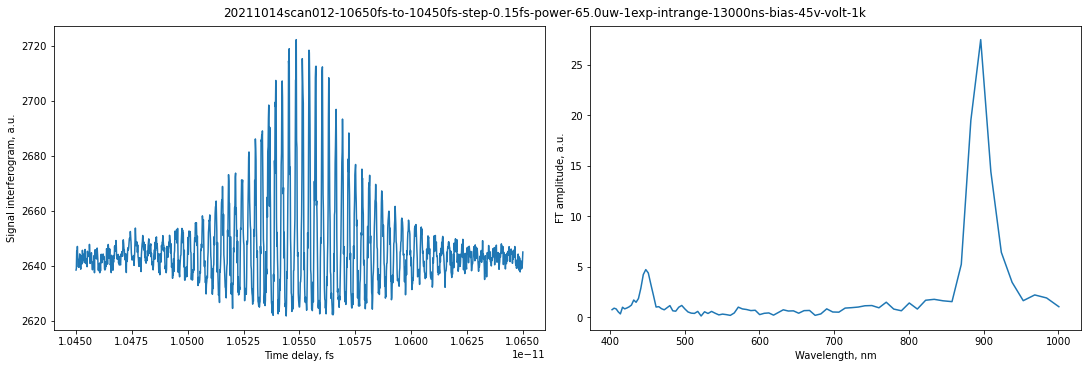

In [103]:
ifgm.display_temporal_and_ft(vs_wavelength=True, 
                             plot_type="both", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

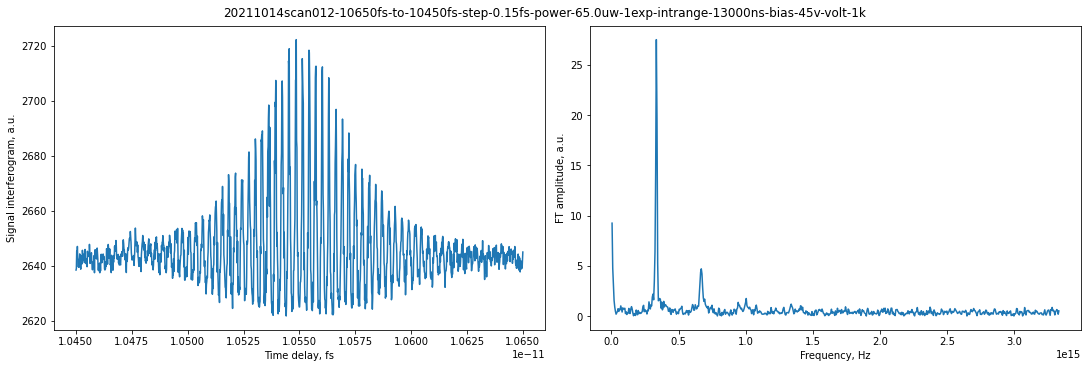

In [104]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="both", 
                             wav_min=400, 
                             wav_max=800, 
                             wav_units="nm")

## Time-frequency analysis

### Normalization

Calling, ```display_temporal_and_ft```method, computes the Fourier transform of the whole signal. 
To determine local spectral characteritics of the signal as it changes over time, there are two options for time-frequency analysis:

* Short time Fourier transform (STFT) - commonly known as a spectrogram
* Wigner-Ville distribution (WVD)

Local spectral characteristics are important, or example, to analyse  the contributions of different harmonics as the signal changes over time.

Prior to application of these methods the data are normalised so that the signal values go from 0 to 8 and the baseline oscillations happen at 1.

* In ```normalizing_width```, set the temporal width of the sampled waveform to use for normalization and the position where it starts.

In [105]:
ifgm.normalize_interferogram(normalizing_width=10e-15, t_norm_start=10550e-15)

normalized mean 1.9387496740128303


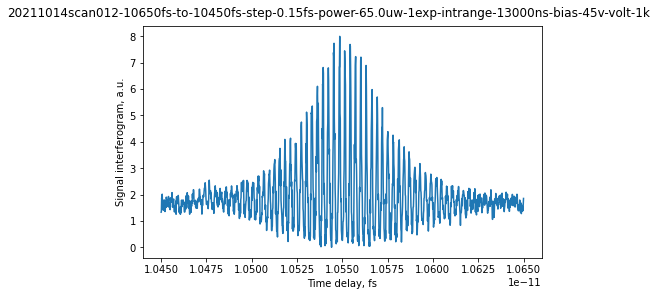

In [106]:
ifgm.display_temporal_and_ft(vs_wavelength=False, 
                             plot_type="temporal", 
                             wav_min=400, 
                             wav_max=1000, 
                             wav_units="nm")

### Spectrogram

* To compute the spectrogram, call ```compute_spectrogram_of_interferogram```method on the intererogram's class instance.
* ```nperse```sets the window size of the short time Fourier transform

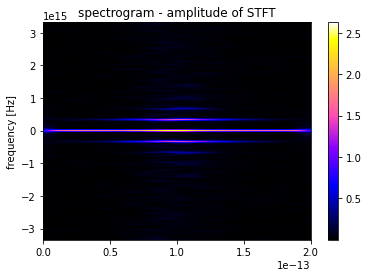

In [107]:
ifgm.compute_spectrogram_of_interferogram(nperseg=2**8,  plotting=True)

### Wigner-Ville transform

* WVT allows to obtain a better temporal resolution than STFT
* Call ```compute_wigner_ville_distribution```method on the intererogram's class instance and specify the parameters. One may need to vary the max and min hue values to avoid clipping.

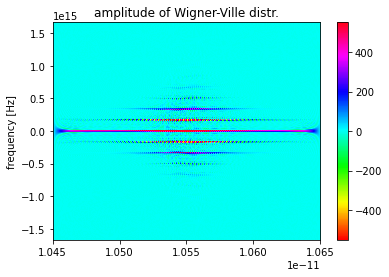

In [108]:
ifgm.compute_wigner_ville_distribution(ifgm.tau_samples, 
                                       ifgm.interferogram, plotting=True, vmin=-550, vmax=550);

## Second-order correlation

### By low-pass filtering

* Compute  the g2 function by low-pass filtering the interferogram. Provide a cutoff frequency and an order of the Butterworth filter to ```gen_g2``` method. 

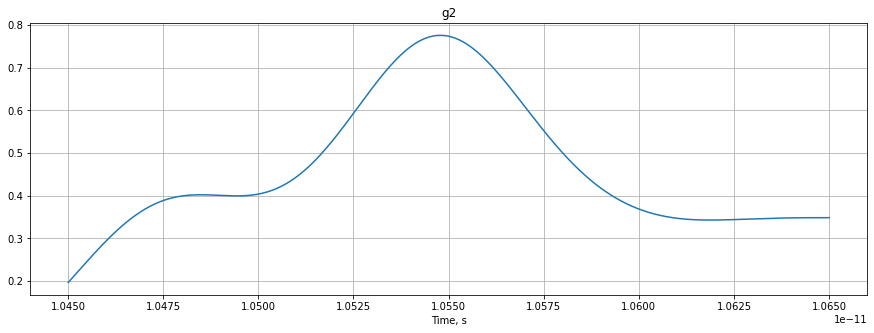

In [109]:
ifgm.gen_g2(filter_cutoff=15e12, filter_order=3, plotting=True)

* To plot the distribution of the g2 function vs. different cut-off frequencies and for different filter orders,
use the ```gen_g2_vs_cutoff```method.
* For coherent light, at zero time delay the g2 function is expected to be 1.
* For illustration purposes, one may want to exclude from plotting those g2 functions
whose values at time delay zero are slightly above or below 1. 
* This can be done by setting g2_min and g2_max arguments.

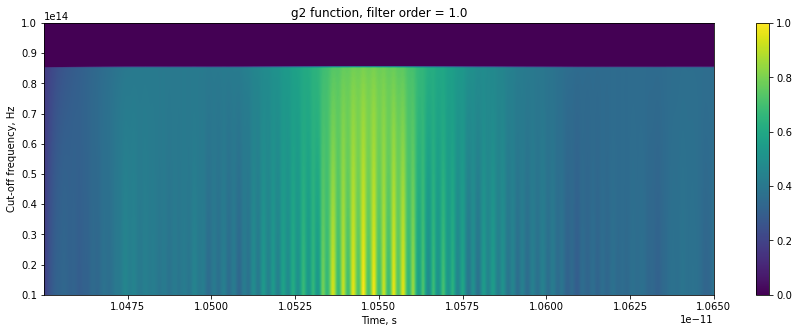

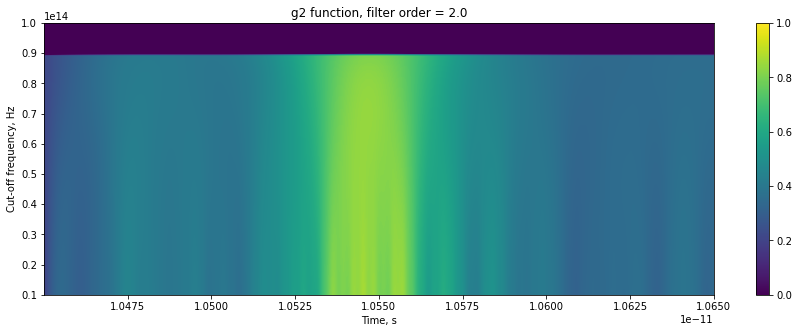

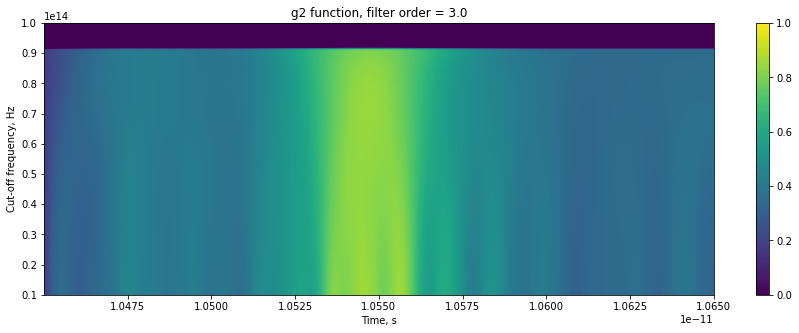

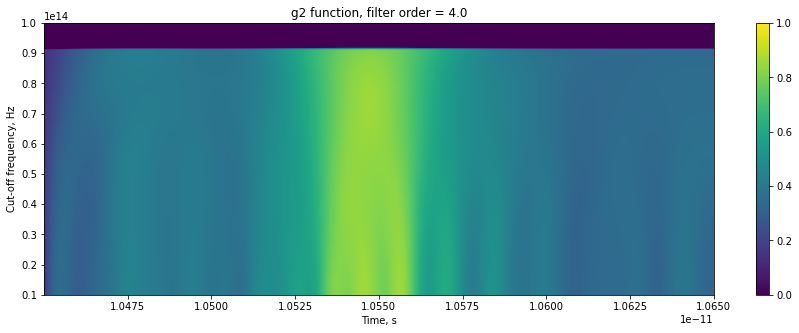

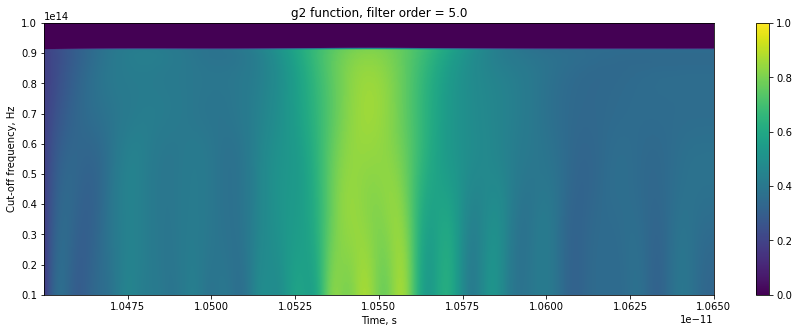

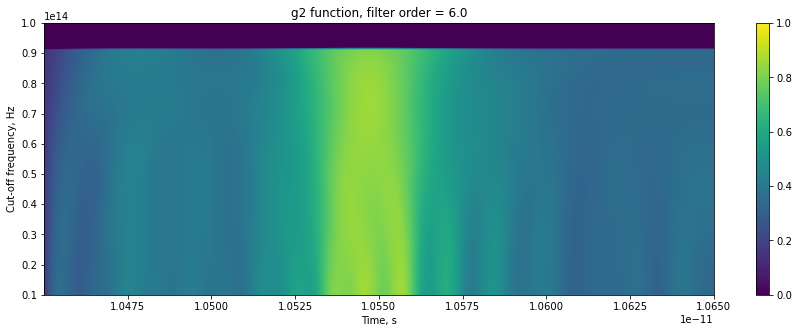

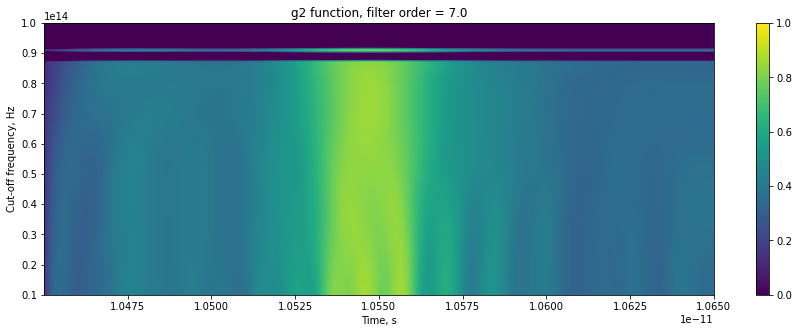

array([[-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       [-1.        , -1.        , -1.        , ..., -1.        ,
        -1.        , -1.        ],
       ...,
       [ 0.16741444,  0.17771622,  0.18793235, ...,  0.3491988 ,
         0.34916483,  0.34913754],
       [ 0.1672072 ,  0.17766317,  0.18803431, ...,  0.3469999 ,
         0.34696279,  0.34693294],
       [ 0.16696148,  0.17755951,  0.18807377, ...,  0.34517207,
         0.34513176,  0.34509931]])

In [98]:
ifgm.gen_g2_vs_cutoff(cutoff_min = 10e12, cutoff_max = 100e12, cutoff_step = 2e12,
                              order_min = 1, order_max = 7, order_step = 1,
                              g2_min = 0.8, g2_max = 1.2,
                              to_plot = True)

## Savitzky-Golay filtering of experimental data

* To eliminate noise in experimental interferograms, apply Savitzky-Golay filter.

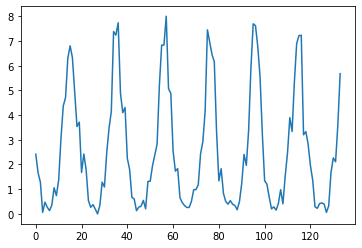

In [110]:
# interferogram before filtering
from matplotlib import pyplot as plt
plt.plot(ifgm.interferogram[600:-600])
plt.show()

In [111]:
# filter (the numbers shall be chosen empirically - think about the physics and the sampling requirements)
ifgm.gen_savitsky_golay_interferogram(window_size=11, order=3)

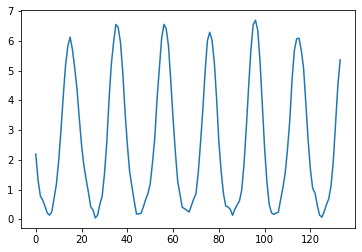

In [112]:
# interferogram after filtering
from matplotlib import pyplot as plt
plt.plot(ifgm.interferogram[600:-600])
plt.show()

* Re-normalise interferogram upon the application of the filter 

In [77]:
ifgm.normalize_interferogram(normalizing_width=10e-15, t_norm_start=10550e-15)

normalized mean 2.2759733719133783


* Compute the g2 function

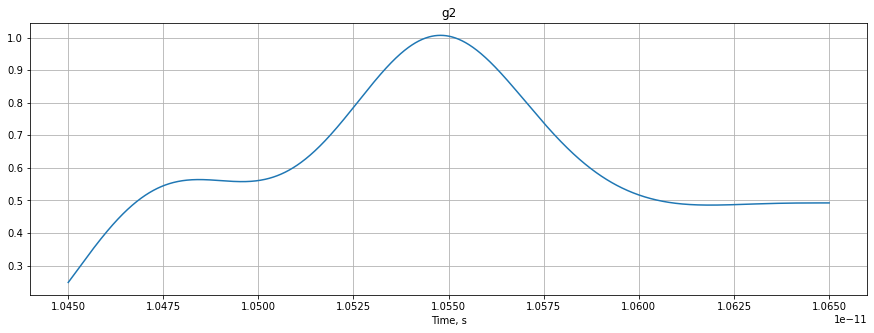

In [78]:
ifgm.gen_g2(filter_cutoff=15e12, filter_order=3, plotting=True)

* The width of the SG filter window can be found empirically. One has to keep in in mind the physics of the process so that all relevant features are kept whilst being filtered.

* Although the g2 function is set by the low-frequency components of the  interferogram and hence should not be influenced by the SG smooting (the size of the window), the relevant features (oscillations at the fundamental and the double frequency) get distorted significantly once the size of the filter's window grows.

* Example of g2 function for different window windths

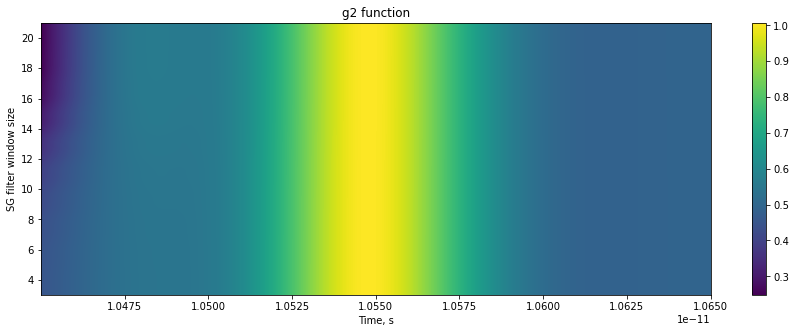

In [88]:
ifgm.gen_g2_vs_savitsky_golay(sg_window_min=3, sg_window_max=21, sg_window_step=2,
                                 sg_order_min=2, sg_order_max=2, sg_order_step=1,
                                 bw_filter_order = 3, bw_filter_cutoff = 15e12,
                                 g2_min=0.99, g2_max=1.01,
                                 to_plot=True);

* Example of distortions introduced by filtering with a large window

In [100]:
# filter (the numbers shall be chosen empirically - think about the physics and the sampling requirements)
ifgm.gen_savitsky_golay_interferogram(window_size=101, order=3)

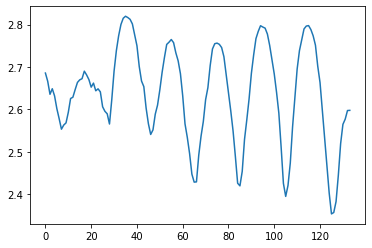

In [101]:
# interferogram after filtering
from matplotlib import pyplot as plt
plt.plot(ifgm.interferogram[600:-600])
plt.show()

## Display all data in any directory

You can also read, analyse and display all data in any directory of interest. It is assumed though that **all data were recorded using the same units of time** (e.g. all datasets have units of e.g. fs)

* Initialize an instance of the class by providing the relevant arguments to ```ifgm = Interferogram()```

    * Provide the datapath to a directory of interest
    * Set the unit of time used whilst recording the data
    * DO NOT set the ```filetoread``` and the ```time_step``` arguments - the code will find them out automatically whilst reading out the data sets.

* Read, analyse and display the dataset by calling the ```display_all()``` module on the instance of the initialized class using the same arguments as with the ```display()``` module.


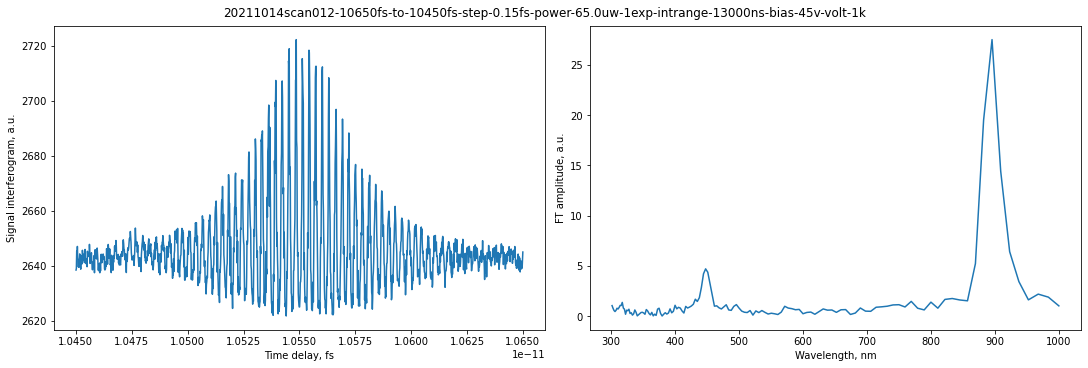

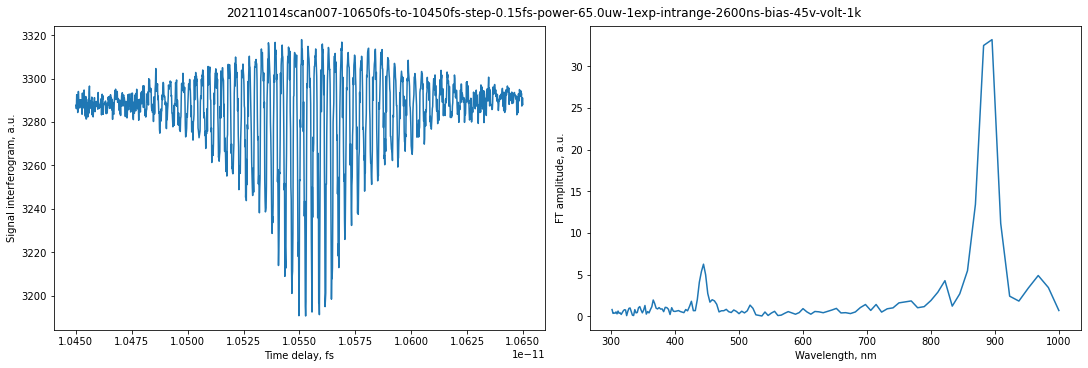

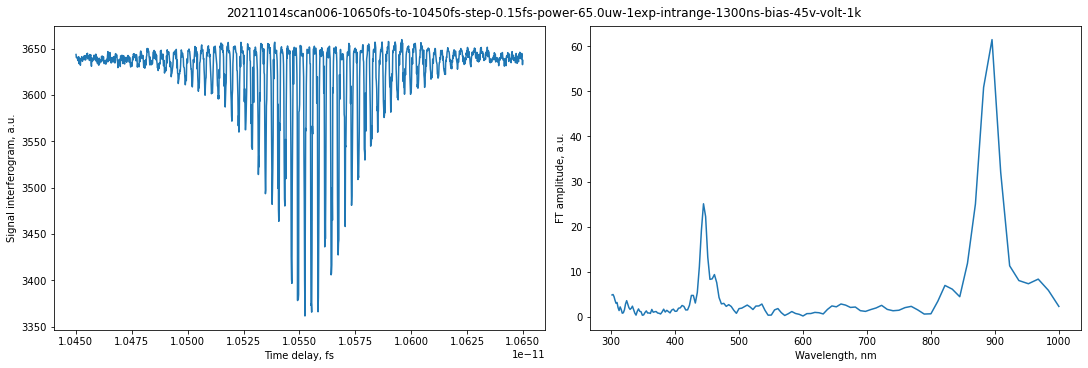

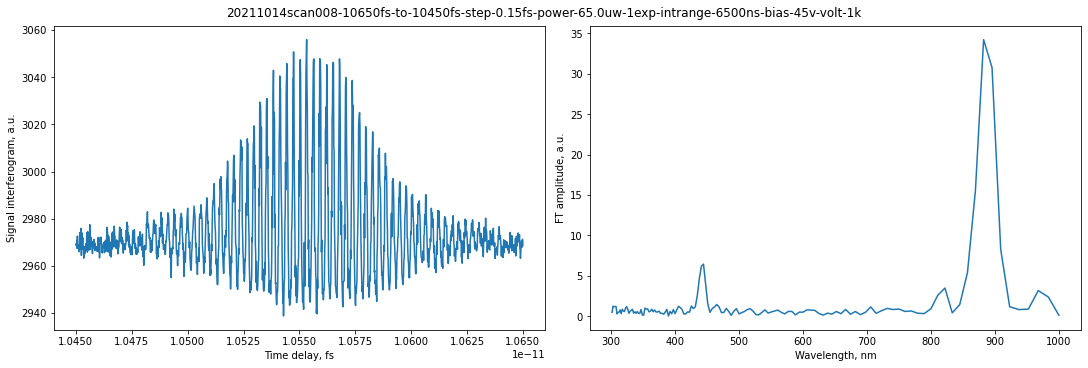

In [21]:
datapath = os.path.abspath("/Users/Pavel/Documents/repos/Interferometry/Interferometry/data/")

ifgm = Interferogram(pathtodata = datapath, tau_units = "fs")

ifgm.display_all(vs_wavelength=True, wav_min=300, wav_max=1000, wav_units="nm")

# Simulated interferograms 

## Field and interferogram distributions

In [26]:
from Interferometry.classes.simulation import Simulation

In [27]:
sim = Simulation(lambd=800e-9, t_fwhm=50e-15, t_phase=0, 
                 t_start=-100e-15, t_end=100e-15, delta_t=0.15e-15,
                 tau_start=-100e-15, tau_end=100e-15, tau_step=0.15e-15)

* Generate an electric field pulse by calling ```gen_e_field```method on he initialised class instance.

/Users/Pavel/anaconda3/envs/interferometry/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


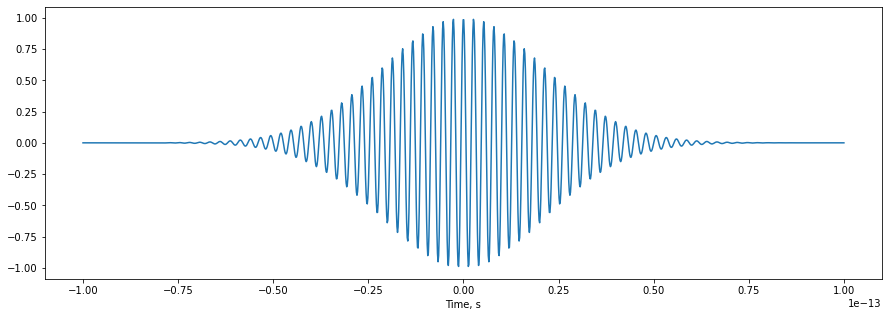

In [28]:
e_t, a_t = sim.gen_e_field(delay=0, plotting=True);

* Generate an interferogram by calling ```gen_interferogram``` method on the initialised class instance.

(1334,)
(1334,)
(1334,)


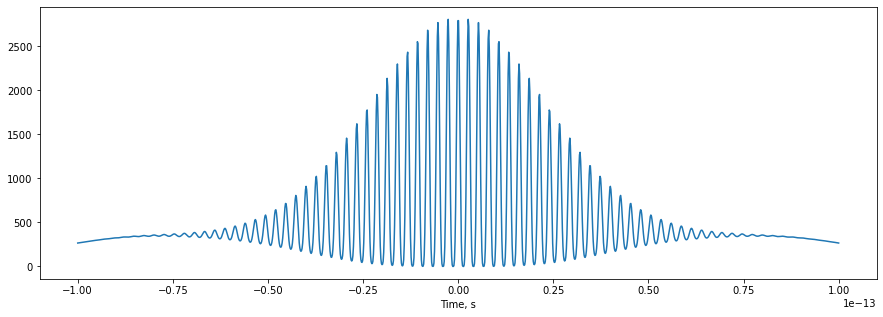

In [29]:
sim.gen_interferogram_simulation(temp_shift=0, plotting=True)

## Time-frequency analysis

* Normalize  an interferogram to have 1 to 8 ratio, just as we did for experimental data.

In [31]:
sim.normalize_interferogram_simulation(normalizing_width=10e-15, t_norm_start=-1000e-15)

* Simulate the g2 function analytically

##### * Compute spectrogram by calling ```compute_spectrogram```mehod on the class instance.
* Optimise the spectral resolution by varying the window size ```nperseg``` argument
* Set ```delta_f=1 / sim.delta_tau```  - should be changed in the future by moving the sim.delta_tau argument to the base class

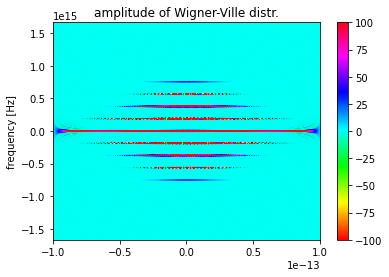

In [49]:
sim.compute_wigner_ville_distribution(sim.tau_samples, sim.interferogram, plotting=True, vmin=-100, vmax=100);

* The g2 function distribution can be generated by calling the ```gen_g2``` method on the instance of the ```Simulation``` class. As an input argument, provide the temporal samples.  

* The g2 function distribution from the simulated data can be generated by calling the ```gen_g2``` method on the instance of the ```Simulation``` class. No input arguments is needed. 

* In order to plot the experiemntal data  

## Second-order correlation function 

### Analytical computation

/Users/Pavel/Documents/repos/Interferometry/Interferometry/classes/simulation.py:231: ComplexWarning: Casting complex values to real discards the imaginary part
  self.g2_analytical[idx] = np.mean(e_t * np.conj(e_t) * e_t_tau * np.conj(e_t_tau) / np.mean((e_t * np.conj(e_t))**2))


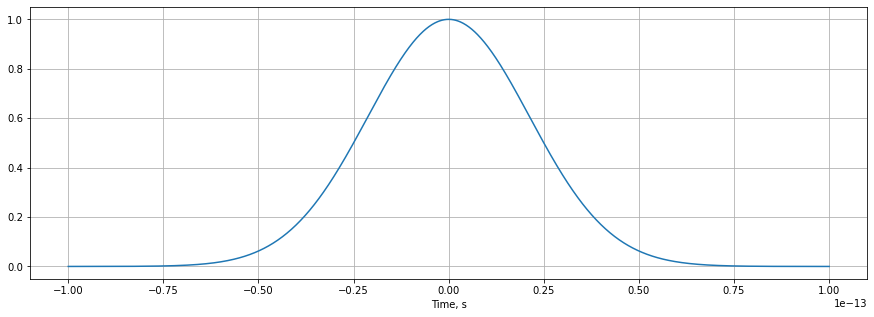

In [33]:
g2 = sim.gen_g2_analytical(plotting=True)

### TODO: Fitted g2

### By low-pass filtering 

* Compute  the g2 function by low-pass filtering the simulated interferogram. Provide a cutoff frequency and an order of the Butterworth filter to ```gen_g2``` method. 

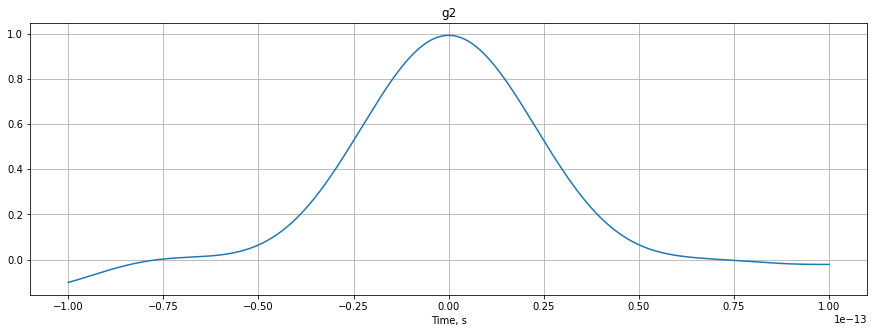

In [48]:
sim.gen_g2(filter_cutoff=20e12, filter_order=3, plotting=True)

* To plot the distribution of the g2 function vs. different cut-off frequencies and for dofferent filter orders,
use the ```gen_g2_vs_cutoff_freq```method.
* For coherent light, at zero time delay the g2 function is expected to be 1.
* For illustration purposes, one may want to exclude from plotting those g2 functions
whose values at time delay zero are slightly above or below 1. 
* This can be done by setting g2_min and g2_max arguments.

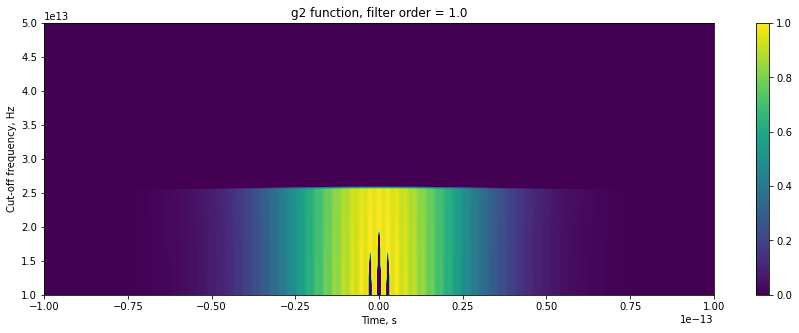

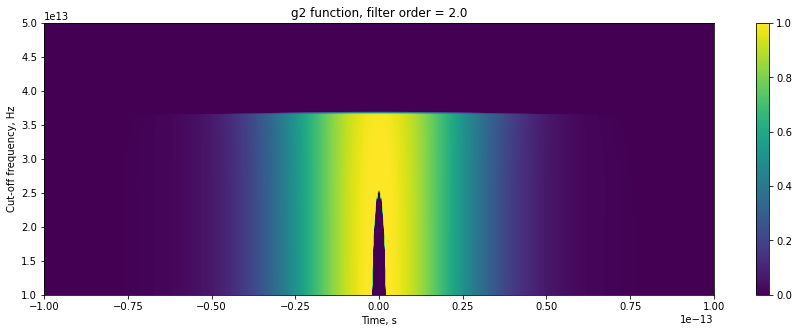

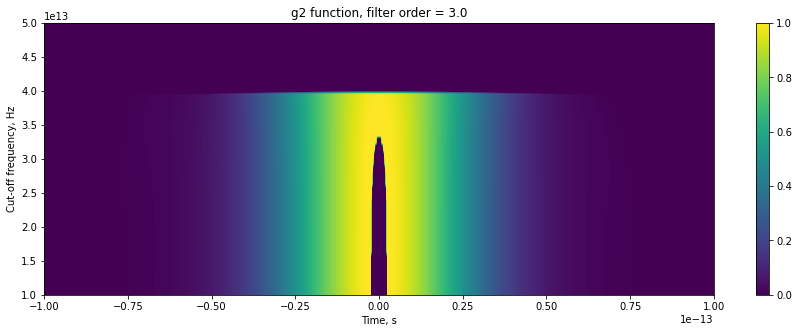

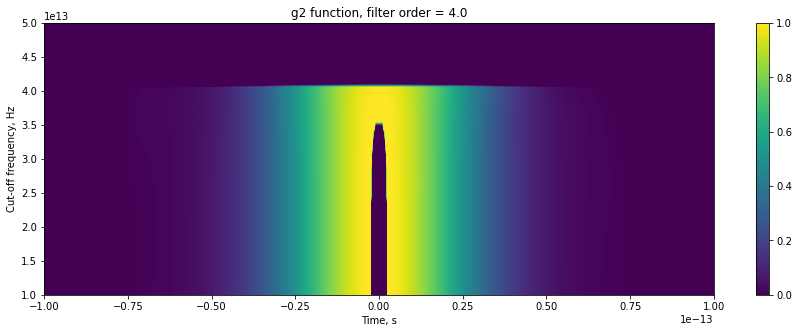

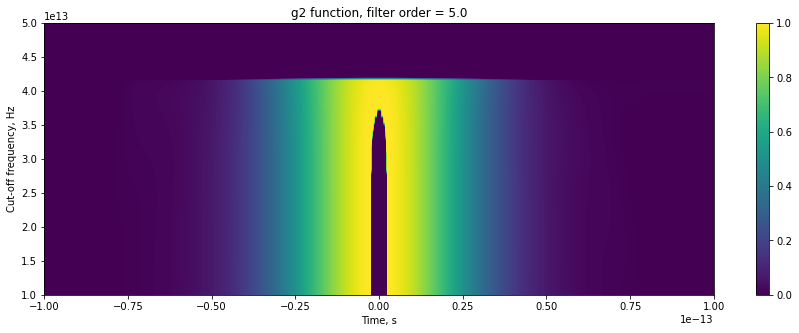

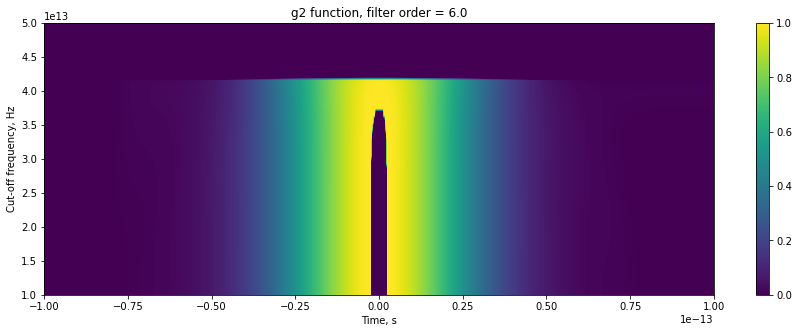

In [41]:
sim.gen_g2_vs_cutoff(cutoff_min = 10e12, cutoff_max = 50e12, cutoff_step = 1e12,
                              order_min = 1, order_max = 6, order_step = 1,
                              g2_min = 0.99, g2_max = 1.01,
                              to_plot = True);